In [1]:
#reads variable from the previous notebook
%store -r train_dataset_by_row validation_dataset_by_row test_dataset_by_row res2

In [2]:
train_dataset_by_row

,Input_Time_Window_Start,Input_Time_Window_End,No. Small hangups,Alarm2Count,Alarm4Count,Alarm10Count,Alarm3Count,Alarm5Count,Alarm90Count,Alarm19Count,...,Machine Failure Failed,Machine Failure Reset,Change Setup,Change Setup Passed,Change Setup Failed,Change Setup Reset,xscation error 1087242244 Count,xscation error 13500912 Count,xscation error 13500638 Count,xscation error 999 Count
0,2021-01-28 00:00:00,2021-01-28 06:00:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2021-01-28 06:00:00,2021-01-28 12:00:00,4,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2021-01-28 12:00:00,2021-01-28 18:00:00,3,0,0,2,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021-01-28 18:00:00,2021-01-29 00:00:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2021-01-29 00:00:00,2021-01-29 06:00:00,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14107,2021-06-08 12:00:00,2021-06-08 18:00:00,21,0,0,1,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
14108,2021-06-08 18:00:00,2021-06-09 00:00:00,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
14109,2021-06-09 00:00:00,2021-06-09 06:00:00,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14110,2021-06-09 06:00:00,2021-06-09 12:00:00,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [2]:
import math 
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, Conv1D, BatchNormalization #import in this exact format to prevent errors
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler #this is to scale the data from 0 to 1 to increase the model training efficiency
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# Changed input data to 3D array and make use of RNN

In [3]:
training_data_len = round(0.75*len(res2)) #90
validation_data_len = round(0.2*len(res2)) #24
test_data_len = len(res2) - training_data_len - validation_data_len #6

#load in train_dataset_by_row validation_dataset_by_row test_dataset_by_row res2
train_dataset_by_row = train_dataset_by_row.drop(['Input_Time_Window_Start', 'Input_Time_Window_End'], axis=1)
validation_dataset_by_row = validation_dataset_by_row.drop(['Input_Time_Window_Start', 'Input_Time_Window_End'], axis=1)
test_dataset_by_row = test_dataset_by_row.drop(['Input_Time_Window_Start', 'Input_Time_Window_End'], axis=1)

In [4]:
import numpy as np

#split data
x_train, y_train = [], []

x_val, y_val = [], []

x_test, y_test = [], []

for i in range(training_data_len): #loops from 0 to 90
    x_data = train_dataset_by_row[i*28:i*28+28]
    y_data = res2.iloc[i]['NoMajorDown']
    x_train.append(x_data)
    y_train.append(y_data)
    
for i in range(validation_data_len): #loops from 0 to 90
    x_data = validation_dataset_by_row[i*28:i*28+28]
    y_data = res2.iloc[training_data_len + i]['NoMajorDown']
    x_val.append(x_data)
    y_val.append(y_data)
    
for i in range(test_data_len): #loops from 0 to 90
    x_data = test_dataset_by_row[i*28:i*28+28]
    y_data = res2.iloc[training_data_len + validation_data_len + i]['NoMajorDown']
    x_test.append(x_data)
    y_test.append(y_data)

In [5]:
#normalize the data for the model to learn better
train_mean = np.mean(x_train)
val_mean = np.mean(x_val)
test_mean = np.mean(x_test)

x_train = x_train/train_mean
x_val = x_val/val_mean
x_test = x_test/test_mean

In [6]:
def convert_to_binary(array): #convert no. major down to binary for classification 
    return [1 if ele!= 0 else 0 for ele in array]

binary_y_train = convert_to_binary(y_train)
binary_y_val = convert_to_binary(y_val)
binary_y_test = convert_to_binary(y_test)

x_train, x_val, x_test = np.array(x_train), np.array(x_val), np.array(x_test)
binary_y_train = np.reshape(binary_y_train, (len(binary_y_train),1,1)) #90 samples, 1 timestamp, 1 feature
binary_y_val = np.reshape(binary_y_val, (len(binary_y_val),1,1))
binary_y_test = np.reshape(binary_y_test, (len(binary_y_test),1,1))

print("All shapes are (batches, timestamps, features)")
print(f'Training data has {x_train.shape}')
print(f'label has {binary_y_train.shape}')

#check this to make sure training and validation data have the same features
print(f'Validation data has {x_val.shape}')
print(f'val_label has {binary_y_val.shape}')

All shapes are (batches, timestamps, features)
Training data has (318, 28, 19)
label has (318, 1, 1)
Validation data has (85, 28, 19)
val_label has (85, 1, 1)


In [7]:
def build_model():
    model = Sequential()
    
    #Input with 32 neurons
    model.add(LSTM(1, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=False))
    
    #output layer
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
    return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1)                 84        
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = model.fit(
    x_train, binary_y_train,
    batch_size=28,
    epochs=400,
    validation_data = (x_val, binary_y_val),
    shuffle=False
    )

Epoch 1/400
12/12 [==============================] - 4s 93ms/step - loss: 0.6980 - binary_accuracy: 0.4245 - val_loss: 0.6934 - val_binary_accuracy: 0.6000
Epoch 2/400
12/12 [==============================] - 0s 14ms/step - loss: 0.6930 - binary_accuracy: 0.5912 - val_loss: 0.6895 - val_binary_accuracy: 0.6941
Epoch 3/400
12/12 [==============================] - 0s 15ms/step - loss: 0.6883 - binary_accuracy: 0.6761 - val_loss: 0.6858 - val_binary_accuracy: 0.7294
Epoch 4/400
12/12 [==============================] - 0s 14ms/step - loss: 0.6837 - binary_accuracy: 0.7862 - val_loss: 0.6821 - val_binary_accuracy: 0.7882
Epoch 5/400
12/12 [==============================] - 0s 20ms/step - loss: 0.6791 - binary_accuracy: 0.8333 - val_loss: 0.6784 - val_binary_accuracy: 0.7882
Epoch 6/400
12/12 [==============================] - 0s 16ms/step - loss: 0.6730 - binary_accuracy: 0.8333 - val_loss: 0.6726 - val_binary_accuracy: 0.7882
Epoch 7/400
12/12 [==============================] - 0s 16ms/ste

12/12 [==============================] - 0s 14ms/step - loss: 0.4497 - binary_accuracy: 0.8333 - val_loss: 0.5172 - val_binary_accuracy: 0.7882
Epoch 106/400
12/12 [==============================] - 0s 14ms/step - loss: 0.4496 - binary_accuracy: 0.8333 - val_loss: 0.5173 - val_binary_accuracy: 0.7882
Epoch 107/400
12/12 [==============================] - 0s 15ms/step - loss: 0.4494 - binary_accuracy: 0.8333 - val_loss: 0.5175 - val_binary_accuracy: 0.7882
Epoch 108/400
12/12 [==============================] - 0s 13ms/step - loss: 0.4492 - binary_accuracy: 0.8333 - val_loss: 0.5176 - val_binary_accuracy: 0.7882
Epoch 109/400
12/12 [==============================] - 0s 13ms/step - loss: 0.4491 - binary_accuracy: 0.8333 - val_loss: 0.5177 - val_binary_accuracy: 0.7882
Epoch 110/400
12/12 [==============================] - 0s 14ms/step - loss: 0.4490 - binary_accuracy: 0.8333 - val_loss: 0.5179 - val_binary_accuracy: 0.7882
Epoch 111/400
12/12 [==============================] - 0s 19ms/ste

Epoch 157/400
12/12 [==============================] - 0s 16ms/step - loss: 0.4432 - binary_accuracy: 0.8333 - val_loss: 0.5236 - val_binary_accuracy: 0.7882
Epoch 158/400
12/12 [==============================] - 0s 15ms/step - loss: 0.4431 - binary_accuracy: 0.8333 - val_loss: 0.5237 - val_binary_accuracy: 0.7882
Epoch 159/400
12/12 [==============================] - 0s 16ms/step - loss: 0.4430 - binary_accuracy: 0.8333 - val_loss: 0.5238 - val_binary_accuracy: 0.7882
Epoch 160/400
12/12 [==============================] - 0s 15ms/step - loss: 0.4429 - binary_accuracy: 0.8333 - val_loss: 0.5239 - val_binary_accuracy: 0.7882
Epoch 161/400
12/12 [==============================] - 0s 15ms/step - loss: 0.4428 - binary_accuracy: 0.8333 - val_loss: 0.5239 - val_binary_accuracy: 0.7882
Epoch 162/400
12/12 [==============================] - 0s 19ms/step - loss: 0.4427 - binary_accuracy: 0.8333 - val_loss: 0.5240 - val_binary_accuracy: 0.7882
Epoch 163/400
12/12 [==============================]

Epoch 209/400
12/12 [==============================] - 0s 16ms/step - loss: 0.4398 - binary_accuracy: 0.8333 - val_loss: 0.5253 - val_binary_accuracy: 0.7882
Epoch 210/400
12/12 [==============================] - 0s 14ms/step - loss: 0.4399 - binary_accuracy: 0.8333 - val_loss: 0.5228 - val_binary_accuracy: 0.7882
Epoch 211/400
12/12 [==============================] - 0s 14ms/step - loss: 0.4397 - binary_accuracy: 0.8333 - val_loss: 0.5253 - val_binary_accuracy: 0.7882
Epoch 212/400
12/12 [==============================] - 0s 14ms/step - loss: 0.4398 - binary_accuracy: 0.8333 - val_loss: 0.5227 - val_binary_accuracy: 0.7882
Epoch 213/400
12/12 [==============================] - 0s 14ms/step - loss: 0.4396 - binary_accuracy: 0.8333 - val_loss: 0.5252 - val_binary_accuracy: 0.7882
Epoch 214/400
12/12 [==============================] - 0s 16ms/step - loss: 0.4397 - binary_accuracy: 0.8333 - val_loss: 0.5226 - val_binary_accuracy: 0.7882
Epoch 215/400
12/12 [==============================]

Epoch 261/400
12/12 [==============================] - 0s 13ms/step - loss: 0.4364 - binary_accuracy: 0.8333 - val_loss: 0.5265 - val_binary_accuracy: 0.7882
Epoch 262/400
12/12 [==============================] - 0s 15ms/step - loss: 0.4357 - binary_accuracy: 0.8333 - val_loss: 0.5252 - val_binary_accuracy: 0.7882
Epoch 263/400
12/12 [==============================] - 0s 14ms/step - loss: 0.4338 - binary_accuracy: 0.8333 - val_loss: 0.5266 - val_binary_accuracy: 0.7882
Epoch 264/400
12/12 [==============================] - 0s 13ms/step - loss: 0.4325 - binary_accuracy: 0.8333 - val_loss: 0.5263 - val_binary_accuracy: 0.7882
Epoch 265/400
12/12 [==============================] - 0s 16ms/step - loss: 0.4322 - binary_accuracy: 0.8333 - val_loss: 0.5270 - val_binary_accuracy: 0.7882
Epoch 266/400
12/12 [==============================] - 0s 14ms/step - loss: 0.4324 - binary_accuracy: 0.8333 - val_loss: 0.5261 - val_binary_accuracy: 0.7882
Epoch 267/400
12/12 [==============================]

Epoch 313/400
12/12 [==============================] - 0s 12ms/step - loss: 0.4295 - binary_accuracy: 0.8333 - val_loss: 0.5290 - val_binary_accuracy: 0.7882
Epoch 314/400
12/12 [==============================] - 0s 13ms/step - loss: 0.4296 - binary_accuracy: 0.8333 - val_loss: 0.5279 - val_binary_accuracy: 0.7882
Epoch 315/400
12/12 [==============================] - 0s 12ms/step - loss: 0.4294 - binary_accuracy: 0.8333 - val_loss: 0.5290 - val_binary_accuracy: 0.7882
Epoch 316/400
12/12 [==============================] - 0s 12ms/step - loss: 0.4295 - binary_accuracy: 0.8333 - val_loss: 0.5279 - val_binary_accuracy: 0.7882
Epoch 317/400
12/12 [==============================] - 0s 16ms/step - loss: 0.4293 - binary_accuracy: 0.8333 - val_loss: 0.5290 - val_binary_accuracy: 0.7882
Epoch 318/400
12/12 [==============================] - 0s 17ms/step - loss: 0.4294 - binary_accuracy: 0.8333 - val_loss: 0.5279 - val_binary_accuracy: 0.7882
Epoch 319/400
12/12 [==============================]

Epoch 365/400
12/12 [==============================] - 0s 20ms/step - loss: 0.4261 - binary_accuracy: 0.8365 - val_loss: 0.5260 - val_binary_accuracy: 0.7882
Epoch 366/400
12/12 [==============================] - 0s 20ms/step - loss: 0.4260 - binary_accuracy: 0.8365 - val_loss: 0.5259 - val_binary_accuracy: 0.7882
Epoch 367/400
12/12 [==============================] - 0s 14ms/step - loss: 0.4260 - binary_accuracy: 0.8365 - val_loss: 0.5258 - val_binary_accuracy: 0.7882
Epoch 368/400
12/12 [==============================] - 0s 15ms/step - loss: 0.4259 - binary_accuracy: 0.8365 - val_loss: 0.5258 - val_binary_accuracy: 0.7882
Epoch 369/400
12/12 [==============================] - 0s 15ms/step - loss: 0.4258 - binary_accuracy: 0.8365 - val_loss: 0.5257 - val_binary_accuracy: 0.7882
Epoch 370/400
12/12 [==============================] - 0s 15ms/step - loss: 0.4258 - binary_accuracy: 0.8365 - val_loss: 0.5256 - val_binary_accuracy: 0.7882
Epoch 371/400
12/12 [==============================]

1/1 [==============================] - 0s 20ms/step - loss: 0.5418 - binary_accuracy: 0.7143


[0.5417856574058533, 0.7142857313156128]

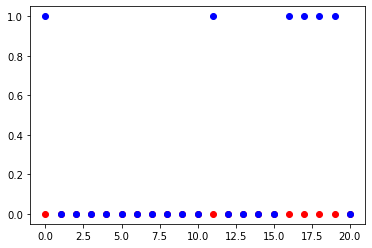

In [9]:
preds = model.predict(x_test)
predictions = (preds>0.5)

import matplotlib.pyplot as plt
plt.scatter(range(len(predictions)),predictions, c='r')
plt.scatter(range(len(binary_y_test)), binary_y_test, c='b')

model.evaluate(x_test, binary_y_test)

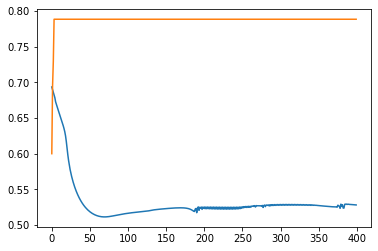

In [10]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_binary_accuracy'])
plt.show()

# Kerastuner to determine how many hidden layers

In [11]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('units', 8, 64, 4, default=8), 
                   return_sequences=True, 
                   input_shape=(x_train.shape[1], x_train.shape[2])))
    
    #determine if we want any hidden layers to increase accuracies
    for i in range(hp.Int("No. of hidden layers", min_value=0, max_value=3)):
        model.add(LSTM(hp.Int('hidden nodes', 8, 64, 4, default=8), 
                       return_sequences=True)) #return sequences set to true will return a 3D tensor which allows the network to be stacked
        model.add(Dropout(0.2))
        
    model.add(LSTM(50, return_sequences=False))

    #include dropout layers
    model.add(Dropout(hp.Float(
                    'dropout',
                    min_value=0.1,
                    max_value=0.8,
                    step=0.1)))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
    return model

In [12]:
tuner = kt.RandomSearch(build_model,
                     objective='val_binary_accuracy',
                     max_trials=3,
                     directory='C://Users//TeyK//Desktop//EQ major down prediction',
                     project_name='EQ Major Down using KT')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=5)

#each model will be trained for 30 epochs and 2 iterations of hyperband search will be run
#model will stop training when callbacks condition is reached to speed up the training process
tuner.search(x_train, binary_y_train, epochs=30, validation_data=(x_val, binary_y_val), callbacks=[stop_early]) 

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

INFO:tensorflow:Reloading Oracle from existing project C://Users//TeyK//Desktop//EQ major down prediction\EQ Major Down using KT\oracle.json
INFO:tensorflow:Reloading Tuner from C://Users//TeyK//Desktop//EQ major down prediction\EQ Major Down using KT\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [13]:
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 28, 56)            17024     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                21400     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 38,475
Trainable params: 38,475
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
10/10 [==============================] - 8s 240ms/step - loss: 0.6151 - binary_accuracy: 0.6824 - val_loss: 0.5445 - val_binary_accuracy: 0.7882
Epoch 2/30
10/10 [==============================] - 0s 37ms/step - loss: 0.4920 - binary_accuracy: 0.8333 - val_loss: 0.5602 - val_binary_accuracy: 0.7882
Epoch 3/30
10/10 [==============================] - 0s 46ms/step - loss: 0.4731 - binary_accuracy: 0.8333 - val_loss: 0.5479 - val_binary_accuracy: 0.7882
Epoch 4/30
10/10 [==============================] - 1s 55ms/step - loss: 0.4588 - binary_accuracy: 0.8333 - val_loss: 0.5401 - val_binary_accuracy: 0.7882
Epoch 5/30
10/10 [==============================] - 1s 58ms/step - loss: 0.4697 - binary_accuracy: 0.8302 - val_loss: 0.5352 - val_binary_accuracy: 0.7882
Epoch 6/30
10/10 [==============================] - 0s 50ms/step - loss: 0.4620 - binary_accuracy: 0.8302 - val_loss: 0.5336 - val_binary_accuracy: 0.7882


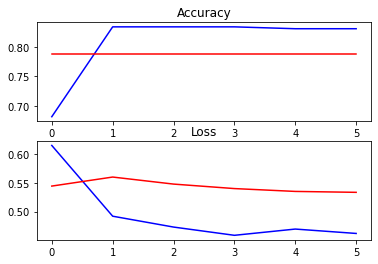

In [14]:
history = best_model.fit(x_train, binary_y_train, epochs=30, 
                         validation_data=(x_val, binary_y_val), callbacks =[stop_early])


fig, (ax1, ax2)= plt.subplots(2)
ax1.plot(history.history['binary_accuracy'], 'b-')
ax1.plot(history.history['val_binary_accuracy'], 'r-')
ax1.set_title('Accuracy')

ax2.plot(history.history['loss'], 'b-')
ax2.plot(history.history['val_loss'], 'r-')
ax2.set_title('Loss')
plt.show()

In [15]:
eval_result = best_model.evaluate(x_test, binary_y_test)
print("[test loss, test binary accuracy]:", eval_result)

1/1 [==============================] - 0s 32ms/step - loss: 0.6446 - binary_accuracy: 0.7143
[test loss, test binary accuracy]: [0.644554853439331, 0.7142857313156128]


In [16]:
LSTM_preds = best_model.predict_classes(x_test)
print(len([ele for ele in y_test if ele ==0])/len(LSTM_preds))

LSTM_preds = np.reshape(LSTM_preds, (LSTM_preds.shape[0],))
LSTM_preds, y_test

C:\Users\TeyK\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.7142857142857143


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Conv 1D layer to recognize sequence

In [17]:
### first find out what parameters to use using keras tuner
def make_model(hp):
    num_layers = hp.Int("num_layers", 1, 3)
    lr = hp.Choice("learning_rate", [1e-3, 5e-4])
    inputs = Input(shape=(x_train.shape[1:])) #input_shape =(batch size, timestamp, no. of features)
    x=inputs
    
    for idx in range(num_layers):
        idx = str(idx)

        filters = hp.Int("filters_" + idx, 32, 256, step=32, default=64)
        x = Conv1D(filters=filters, kernel_size=3, padding="same", activation="relu")(x)
        x = BatchNormalization()(x)
        
    gap = keras.layers.GlobalAveragePooling1D()(x)
    output_layer = Dense(1, activation="sigmoid")(gap)
    
    model = keras.Model(inputs, output_layer)
    model.compile(optimizer=optimizers.Adam(lr), loss='binary_crossentropy', metrics=['binary_accuracy'])
    
    return model

In [18]:
tuner = kt.RandomSearch(
            make_model,
            objective='val_binary_accuracy',
            max_trials = 3,
            project_name='Conv1D tuner search'
            )

INFO:tensorflow:Reloading Oracle from existing project .\Conv1D tuner search\oracle.json
INFO:tensorflow:Reloading Tuner from .\Conv1D tuner search\tuner0.json


In [19]:
BATCH_SIZE = 32
EPOCHS = 30
stopearly = EarlyStopping(monitor="val_loss", patience=50, verbose=1)
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss")

tuner.search(x_train, binary_y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data=(x_val, binary_y_val), callbacks=[checkpoint, stopearly])
tuner.results_summary()

INFO:tensorflow:Oracle triggered exit
Results summary
Results in .\Conv1D tuner search
Showing 10 best trials
Objective(name='val_binary_accuracy', direction='max')
Trial summary
Hyperparameters:
num_layers: 3
learning_rate: 0.001
filters_0: 64
filters_1: 224
filters_2: 64
Score: 0.800000011920929
Trial summary
Hyperparameters:
num_layers: 2
learning_rate: 0.0005
filters_0: 160
filters_1: 64
Score: 0.800000011920929
Trial summary
Hyperparameters:
num_layers: 3
learning_rate: 0.0005
filters_0: 32
filters_1: 64
filters_2: 64
Score: 0.7882353067398071


In [20]:
best_model = load_model('best_model.h5')
best_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 19)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 28, 160)           9280      
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 160)           640       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 64)            30784     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 64)            256       
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65    

In [21]:
history = best_model.fit(x_train, binary_y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                         validation_data=(x_val,binary_y_val), callbacks=[checkpoint, stopearly])

Epoch 1/30
10/10 [==============================] - 2s 61ms/step - loss: 0.3733 - binary_accuracy: 0.8648 - val_loss: 0.5527 - val_binary_accuracy: 0.7882
Epoch 2/30
10/10 [==============================] - 0s 26ms/step - loss: 0.3718 - binary_accuracy: 0.8616 - val_loss: 0.5523 - val_binary_accuracy: 0.7882
Epoch 3/30
10/10 [==============================] - 0s 18ms/step - loss: 0.3651 - binary_accuracy: 0.8679 - val_loss: 0.5532 - val_binary_accuracy: 0.7882
Epoch 4/30
10/10 [==============================] - 0s 20ms/step - loss: 0.3540 - binary_accuracy: 0.8836 - val_loss: 0.5719 - val_binary_accuracy: 0.7882
Epoch 5/30
10/10 [==============================] - 0s 19ms/step - loss: 0.3446 - binary_accuracy: 0.8742 - val_loss: 0.5517 - val_binary_accuracy: 0.7882
Epoch 6/30
10/10 [==============================] - 0s 16ms/step - loss: 0.3427 - binary_accuracy: 0.8648 - val_loss: 0.5660 - val_binary_accuracy: 0.7882
Epoch 7/30
10/10 [==============================] - 0s 21ms/step - los

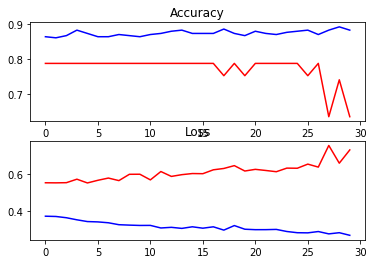

In [22]:
fig, (ax1, ax2)= plt.subplots(2)
ax1.plot(history.history['binary_accuracy'], 'b-')
ax1.plot(history.history['val_binary_accuracy'], 'r-')
ax1.set_title('Accuracy')

ax2.plot(history.history['loss'], 'b-')
ax2.plot(history.history['val_loss'], 'r-')
ax2.set_title('Loss')
plt.show()

In [23]:
test_loss, test_acc = best_model.evaluate(x_test, binary_y_test)
print("Test loss: ", test_loss, " Test acc: ", test_acc)

1/1 [==============================] - 0s 60ms/step - loss: 0.8487 - binary_accuracy: 0.7143
Test loss:  0.8487259745597839  Test acc:  0.7142857313156128


In [24]:
CONV1D_preds = best_model.predict(x_test)
new_CONV1D_preds = (CONV1D_preds > 0.5).astype('int32')
print(len([ele for ele in y_test if ele ==0])/len(new_CONV1D_preds))

new_CONV1D_preds = np.reshape(new_CONV1D_preds, (new_CONV1D_preds.shape[0],))
new_CONV1D_preds, y_test

0.7142857142857143


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Predict using CNN (ignore sequence)

In [95]:
data = res2.drop(['Input_Time_Window_Start', 'Input_Time_Window_End', 
                  'Target_Time_Window_Start', 'Target_Time_Window_End', 'NoMajorDown'], axis=1)
target = convert_to_binary(res2['NoMajorDown'])

TEST_SPLIT = 0.1 
VAL_SPLIT = 0.2

x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=TEST_SPLIT, random_state=42)
from imblearn.over_sampling import SMOTE
from collections import Counter

sm = SMOTE(random_state=42)
x_train, y_train = sm.fit_resample(x_train, y_train)
print(Counter(y_train))

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=VAL_SPLIT, random_state=42)
print(Counter(y_train))

Counter({0: 313, 1: 313})
Counter({1: 257, 0: 243})


In [96]:
x_train, x_val, x_test = np.array(x_train), np.array(x_val), np.array(x_test)
y_train, y_val, y_test = np.array(y_train), np.array(y_val), np.array(y_test)

In [97]:
def build_model(hp):
    model = Sequential()
    
    model.add(Dense(hp.Int('Input neurons',32,256,32), activation='relu', 
                    input_shape=(x_train.shape[1],)))
    
    for i in range(hp.Int("No. hidden layers", 0,3)):
        model.add(Dense(hp.Int('Input neurons',32,256,32), activation='relu'))
    
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
                  
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
    return model

In [98]:
tuner = kt.RandomSearch(build_model,
                     objective='val_binary_accuracy',
                     max_trials=3,
                     directory='C://Users//TeyK//Desktop//EQ major down prediction',
                     project_name='Dense Classification')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=5)

In [99]:
BATCH_SIZE = 32
EPOCHS = 100
stopearly = EarlyStopping(monitor="val_loss", patience=50, verbose=1)
checkpoint = ModelCheckpoint("best_dense_model.h5", save_best_only=True, monitor="val_loss")

tuner.search(x_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data=(x_val, y_val), callbacks=[checkpoint, stopearly])
tuner.results_summary()

Trial 3 Complete [00h 00m 16s]
val_binary_accuracy: 0.7777777910232544

Best val_binary_accuracy So Far: 0.8015872836112976
Total elapsed time: 00h 00m 53s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in C://Users//TeyK//Desktop//EQ major down prediction\Dense Classification
Showing 10 best trials
Objective(name='val_binary_accuracy', direction='max')
Trial summary
Hyperparameters:
Input neurons: 160
No. hidden layers: 0
Score: 0.8015872836112976
Trial summary
Hyperparameters:
Input neurons: 32
No. hidden layers: 1
Score: 0.7777777910232544
Trial summary
Hyperparameters:
Input neurons: 128
No. hidden layers: 0
Score: 0.738095223903656


Epoch 1/400
16/16 [==============================] - 1s 14ms/step - loss: 0.4065 - binary_accuracy: 0.7840 - val_loss: 0.5046 - val_binary_accuracy: 0.7460
Epoch 2/400
16/16 [==============================] - 0s 4ms/step - loss: 0.3940 - binary_accuracy: 0.8200 - val_loss: 0.5016 - val_binary_accuracy: 0.7619
Epoch 3/400
16/16 [==============================] - 0s 3ms/step - loss: 0.3922 - binary_accuracy: 0.8220 - val_loss: 0.5203 - val_binary_accuracy: 0.7540
Epoch 4/400
16/16 [==============================] - 0s 3ms/step - loss: 0.3982 - binary_accuracy: 0.8180 - val_loss: 0.4999 - val_binary_accuracy: 0.7540
Epoch 5/400
16/16 [==============================] - 0s 3ms/step - loss: 0.4066 - binary_accuracy: 0.8080 - val_loss: 0.5205 - val_binary_accuracy: 0.7619
Epoch 6/400
16/16 [==============================] - 0s 5ms/step - loss: 0.4264 - binary_accuracy: 0.8020 - val_loss: 0.4908 - val_binary_accuracy: 0.7540
Epoch 7/400
16/16 [==============================] - 0s 4ms/step - lo

16/16 [==============================] - 0s 4ms/step - loss: 0.3453 - binary_accuracy: 0.8480 - val_loss: 0.4759 - val_binary_accuracy: 0.7460
Epoch 106/400
16/16 [==============================] - 0s 3ms/step - loss: 0.3478 - binary_accuracy: 0.8260 - val_loss: 0.4863 - val_binary_accuracy: 0.7698
Epoch 107/400
16/16 [==============================] - 0s 3ms/step - loss: 0.3147 - binary_accuracy: 0.8660 - val_loss: 0.4866 - val_binary_accuracy: 0.7698
Epoch 108/400
16/16 [==============================] - 0s 4ms/step - loss: 0.3410 - binary_accuracy: 0.8360 - val_loss: 0.4927 - val_binary_accuracy: 0.7302
Epoch 109/400
16/16 [==============================] - 0s 3ms/step - loss: 0.3365 - binary_accuracy: 0.8400 - val_loss: 0.4964 - val_binary_accuracy: 0.7540
Epoch 110/400
16/16 [==============================] - 0s 3ms/step - loss: 0.3274 - binary_accuracy: 0.8400 - val_loss: 0.4330 - val_binary_accuracy: 0.8095
Epoch 111/400
16/16 [==============================] - 0s 3ms/step - los

Epoch 209/400
16/16 [==============================] - 0s 3ms/step - loss: 0.2850 - binary_accuracy: 0.8660 - val_loss: 0.4456 - val_binary_accuracy: 0.7937
Epoch 210/400
16/16 [==============================] - 0s 3ms/step - loss: 0.2602 - binary_accuracy: 0.8820 - val_loss: 0.4420 - val_binary_accuracy: 0.7937
Epoch 211/400
16/16 [==============================] - 0s 3ms/step - loss: 0.2733 - binary_accuracy: 0.8700 - val_loss: 0.4544 - val_binary_accuracy: 0.8016
Epoch 212/400
16/16 [==============================] - 0s 3ms/step - loss: 0.2706 - binary_accuracy: 0.8740 - val_loss: 0.4632 - val_binary_accuracy: 0.8016
Epoch 213/400
16/16 [==============================] - 0s 3ms/step - loss: 0.2634 - binary_accuracy: 0.8760 - val_loss: 0.4560 - val_binary_accuracy: 0.8016
Epoch 214/400
16/16 [==============================] - 0s 3ms/step - loss: 0.2576 - binary_accuracy: 0.8860 - val_loss: 0.4135 - val_binary_accuracy: 0.7778
Epoch 215/400
16/16 [==============================] - 0s 

Epoch 261/400
16/16 [==============================] - 0s 3ms/step - loss: 0.3356 - binary_accuracy: 0.8760 - val_loss: 0.4395 - val_binary_accuracy: 0.7857
Epoch 262/400
16/16 [==============================] - 0s 3ms/step - loss: 0.2880 - binary_accuracy: 0.8700 - val_loss: 0.4837 - val_binary_accuracy: 0.7619
Epoch 263/400
16/16 [==============================] - 0s 3ms/step - loss: 0.3441 - binary_accuracy: 0.8540 - val_loss: 0.5453 - val_binary_accuracy: 0.7619
Epoch 264/400
16/16 [==============================] - 0s 3ms/step - loss: 0.3134 - binary_accuracy: 0.8640 - val_loss: 0.4326 - val_binary_accuracy: 0.8175
Epoch 265/400
16/16 [==============================] - 0s 3ms/step - loss: 0.3161 - binary_accuracy: 0.8660 - val_loss: 0.4849 - val_binary_accuracy: 0.7937
Epoch 266/400
16/16 [==============================] - 0s 3ms/step - loss: 0.2864 - binary_accuracy: 0.8780 - val_loss: 0.4068 - val_binary_accuracy: 0.8333
Epoch 267/400
16/16 [==============================] - 0s 

16/16 [==============================] - 0s 3ms/step - loss: 0.2099 - binary_accuracy: 0.9180 - val_loss: 0.3749 - val_binary_accuracy: 0.8095
Epoch 366/400
16/16 [==============================] - 0s 3ms/step - loss: 0.2288 - binary_accuracy: 0.8840 - val_loss: 0.4024 - val_binary_accuracy: 0.8254
Epoch 367/400
16/16 [==============================] - 0s 3ms/step - loss: 0.2393 - binary_accuracy: 0.9040 - val_loss: 0.3966 - val_binary_accuracy: 0.8175
Epoch 368/400
16/16 [==============================] - 0s 3ms/step - loss: 0.2014 - binary_accuracy: 0.9240 - val_loss: 0.4195 - val_binary_accuracy: 0.8413
Epoch 369/400
16/16 [==============================] - 0s 3ms/step - loss: 0.1957 - binary_accuracy: 0.9220 - val_loss: 0.3640 - val_binary_accuracy: 0.8413
Epoch 370/400
16/16 [==============================] - 0s 3ms/step - loss: 0.1965 - binary_accuracy: 0.9120 - val_loss: 0.4115 - val_binary_accuracy: 0.8175
Epoch 371/400
16/16 [==============================] - 0s 3ms/step - los

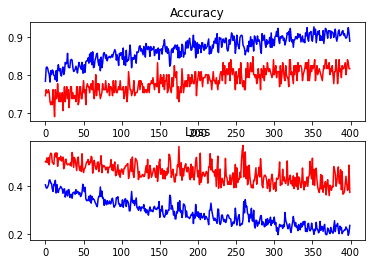

2/2 [==============================] - 0s 3ms/step - loss: 2.0254 - binary_accuracy: 0.7209
Test loss:  2.0253641605377197  Test binary accuracy:  0.7209302186965942


In [100]:
model = load_model('best_dense_model.h5')

history = model.fit(x_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data=(x_val, y_val))
fig, (ax1, ax2)= plt.subplots(2)
ax1.plot(history.history['binary_accuracy'], 'b-')
ax1.plot(history.history['val_binary_accuracy'], 'r-')
ax1.set_title('Accuracy')

ax2.plot(history.history['loss'], 'b-')
ax2.plot(history.history['val_loss'], 'r-')
ax2.set_title('Loss')
plt.show()

loss, accuracy = model.evaluate(x_test, y_test)
print("Test loss: ", loss, " Test binary accuracy: ", accuracy)

In [101]:
preds = model.predict_classes(x_test)
len([ele for ele in y_test if ele ==0])/len(preds)

preds = np.reshape(preds, (preds.shape[0],))
preds

C:\Users\TeyK\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0])

In [102]:
y_test

array([0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [105]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                800       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,889
Trainable params: 1,889
Non-trainable params: 0
_________________________________________________________________


# Dense layer

In [103]:
# list down all the features
# anova, correlation matrix, fft(show relationsip between column and label)


# make this a binary classification question
# exactly when the major down will happen (shorten the target time window)
# multiple output prediction (what kind of major down, when it happens, and what is the state name)